# COMP5329 - Deep Learning
## Assignment 2 - Multilabel Classification

*   Nirav Desai
*   Rebecca Chan



## Initial Set up
### Load packages

In [ ]:
## Load libraries
import re, os
import pandas as pd
from io import StringIO
from google.colab import drive

%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import time
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import itertools
import os

from torchvision import datasets, transforms
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix
from datetime import timedelta
from torch import optim
import torchvision.models as models

torch.__version__

'1.8.1+cu101'

##### Use GPU if available

In [ ]:
use_cuda = True if torch.cuda.is_available() else False
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('We are using GPU.' if use_cuda else 'We are using CPU.')


We are using GPU.


##### Mount google drive

In [ ]:
drive.mount('/content/gdrives')
data_path = '/content/gdrives/MyDrive/COMP5329/COMP5329S1A2Dataset'

Mounted at /content/gdrives


In [ ]:
train_set = '/content/gdrives/MyDrive/COMP5329/COMP5329S1A2Dataset/train.csv'
with open(train_set) as train: 
  lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in train]
  df_train = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

df_train.head()


,ImageID,Labels,Caption
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.
1,1.jpg,1 19,A couple of men riding horses on top of a gree...
2,2.jpg,1,They are brave for riding in the jungle on tho...
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.


## Load Dataset Function

**Inputs:**
  1. Root Directory for Images
  2. csv filename with annotations
  3. Pytorch transform object

**Outputs:**
  - Training and Validation Set
    - tuple with image as a tensor and corresponding target One-Hot encoded label as tensor (image, label)
  - Test Set
    - image as a tensor

In [ ]:
class load_data(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        with open(root_dir+'/'+annotation_file) as train: 
          lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in train]
          train_labels = pd.read_csv(StringIO(''.join(lines)), escapechar="/", encoding='utf-8')

        self.root_dir = root_dir
        self.annotations = train_labels
        self.transform = transform


    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index, 0]
        img = Image.open(os.path.join(self.root_dir+'/data', img_id)).convert("RGB")
        split_label = self.annotations.iloc[index, 1].split()
        num_labels = list(map(int, split_label))
        label = torch.LongTensor(num_labels) - 1
        one_hot_labels = torch.zeros(size=([19]), dtype=torch.float32)
        # print(label, self.one_hot_labels.shape, label.shape)
        y_label = one_hot_labels.scatter_(dim=0, index=label, value=1.)
        # y_label = torch.tensor(float(self.annotations.iloc[index, 1]))

        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)

In [ ]:
# For TEST data

class load_test_data(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None): 
        with open(root_dir + '/' + annotation_file) as test: 
          lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in test]
          test_labels = pd.read_csv(StringIO(''.join(lines)), escapechar="/", encoding='utf-8')    

        self.root_dir = root_dir
        self.annotations = test_labels
        self.transform = transform
      
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index,0]
        img = Image.open(os.path.join(self.root_dir+'/data', img_id)).convert("RGB")

        if self.transform is not None: 
            img = self.transform(img)

        return (img)

## Image Pre-processing and Augmentation

- Augmentation Techniues such as:
  - Crop
  - Resize
  - Flipping (Horizontal and Vertical)
  - Rotation
  - Brightness Changes
- Normalize
- Load raw data and split into Training and Validation
- Create pytorch DataLoader instance for Train, Validation and Test set

In [ ]:
# https://stackoverflow.com/questions/56774582/adding-custom-labels-to-pytorch-dataloader-dataset-does-not-work-for-custom-data (for adding labels)
# https://medium.com/analytics-vidhya/implementing-cnn-in-pytorch-with-custom-dataset-and-transfer-learning-1864daac14cc (maybe better?)
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html try this

# DataLoader Parameters
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
kwargs['batch_size'] = 16  # Batch size used during training.
shuffle=True
batch_size = 128
num_workers = 2
pin_memory = True

# Transform for data pre-processing
transform = transforms.Compose([transforms.Resize(240), 
                                transforms.CenterCrop(224),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.4914, 0.48216, 0.44653), (0.24703, 0.24349, 0.26159))
                                ])

# raw_dataset = load_data(data_path,"train_1100.csv",transform=transform)
# raw_dataset = load_data(data_path,"train_100.csv",transform=transform)
raw_dataset = load_data(data_path,"train.csv",transform=transform)

# Train - Validation split
total_raw_data = len(raw_dataset)
train_valid_split = 0.2 ## Creating a small dataset to work on... (only using 20% of samples as training until model is finalised)
valid_record_size = int(train_valid_split * total_raw_data)
train_record_size = int(total_raw_data - valid_record_size)
print(train_record_size, valid_record_size)

train_set, validation_set = torch.utils.data.random_split(raw_dataset, [train_record_size,valid_record_size])

train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                           shuffle=shuffle, 
                                           batch_size=batch_size,
                                           num_workers=num_workers,
                                           pin_memory=pin_memory)

validation_loader = torch.utils.data.DataLoader(dataset=validation_set, 
                                                shuffle=shuffle, 
                                                batch_size=batch_size,
                                                num_workers=num_workers, 
                                                pin_memory=pin_memory)

print('Dataloaders initialized.')

images, labels = next(iter(train_loader))
print('Shape of an image batch:', images.size())

# Should be approx. 40,000 images (30,000 for training, 10,000 for testing)
print('No. images loaded: ',len(train_loader)*batch_size)


23997 5999
Dataloaders initialized.
Shape of an image batch: torch.Size([128, 3, 224, 224])
No. images loaded:  24064


In [ ]:
# print a batch of labels
print(labels.size())

torch.Size([128, 19])


## Exploratory Dataset Analysis

#### Training Labels

In [ ]:
a = raw_dataset.annotations['Labels'][train_set.indices]
type(a)
b=a.str.split()
c=b.explode().value_counts()
c.index = c.index.astype(int)
print(type(c))
# print(a[1], b[1])
d = c.sort_index()
print(d)
e = d.to_numpy()
print(e)
# f = np.insert(e,8,0) # for missing label 9, inserting 0
f = np.insert(e,11,0) # for missing label 12, inserting 0
print(f, len(f))


<class 'pandas.core.series.Series'>
1     18260
2       949
3      3512
4      1031
5       923
6      1139
7       961
8      1753
9       822
10     1205
11      466
13      471
14      200
15     1569
16      869
17     1113
18     1216
19      786
Name: Labels, dtype: int64
[18260   949  3512  1031   923  1139   961  1753   822  1205   466   471
   200  1569   869  1113  1216   786]
[18260   949  3512  1031   923  1139   961  1753   822  1205   466     0
   471   200  1569   869  1113  1216   786] 19


#### Weight calculation per sample class

In [ ]:
class_counts = f
num_samples = sum(class_counts)

class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
# weights = [class_weights[labels_temp[i]] for i in range(int(num_samples))]
# class_weights[8] = 0
class_weights[11] = 0
print(type(class_weights),class_weights)
smp = np.array(class_weights)
print(type(smp),smp)
sss = torch.from_numpy(smp).float().to(dev)
print(type(sss),sss)


<class 'list'> [2.0397042716319826, 39.24657534246575, 10.60506833712984, 36.12512124151309, 40.352112676056336, 32.699736611062335, 38.75650364203954, 21.246434683399887, 45.31021897810219, 30.90871369294606, 79.92489270386267, 0, 79.07643312101911, 186.225, 23.738049713193117, 42.859608745684696, 33.463611859838274, 30.629111842105264, 47.38549618320611]
<class 'numpy.ndarray'> [  2.03970427  39.24657534  10.60506834  36.12512124  40.35211268
  32.69973661  38.75650364  21.24643468  45.31021898  30.90871369
  79.9248927    0.          79.07643312 186.225       23.73804971
  42.85960875  33.46361186  30.62911184  47.38549618]
<class 'torch.Tensor'> tensor([  2.0397,  39.2466,  10.6051,  36.1251,  40.3521,  32.6997,  38.7565,
         21.2464,  45.3102,  30.9087,  79.9249,   0.0000,  79.0764, 186.2250,
         23.7381,  42.8596,  33.4636,  30.6291,  47.3855], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in long_scalars
  """


In [ ]:
def calc_label_weights(n_classes, samples_classes, pw=1):
    label_weightage = 1.0 / np.array(np.power(samples_classes, pw))
    label_weightage = label_weightage / np.sum(label_weightage) * n_classes
    return label_weightage



#### Display Sample Images after Pre-processing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index : 0
image label : tensor([1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0.], device='cuda:0')


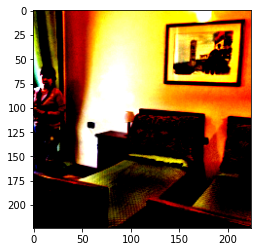

index : 1
image label : tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0.], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


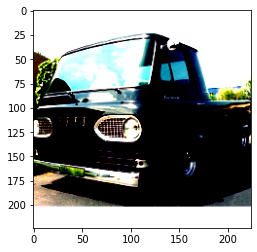

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index : 2
image label : tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.], device='cuda:0')


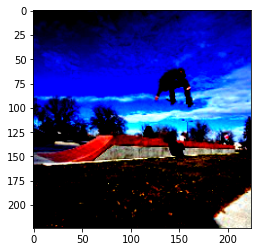

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index : 3
image label : tensor([0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0.], device='cuda:0')


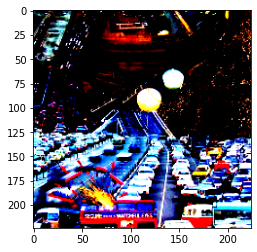

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index : 4
image label : tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0.], device='cuda:0')


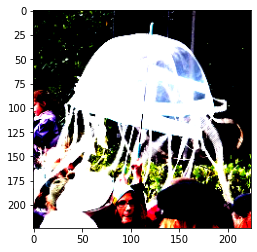

done!


In [ ]:
## Reconstruct some images -- note: images have been normalised 
for i in range(5):
    print('index : {}'.format(i))
    print('image label : {}'.format(labels[i]))
    npimg = images[i].numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

print('done!')

## Modelling stage:

##### Pre-trained Resnext50_32X4d

In [ ]:
class Resnext50(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        resnet = models.resnet50_32x4d(pretrained=True)
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))



##### Removing gradients for re-training and ignoring pre-trained gradients

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

#### Create pre-trained ResNet18

In [ ]:
# Implement a simple NN for testing 
feature_extract = True

class Resnet50(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        resnet = models.resnet18(pretrained=True)
        set_parameter_requires_grad(resnet, feature_extract)
        resnet.fc = nn.Sequential(
            # nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))
        # return self.base_model(x)

# Initialize model
model = Resnet50(19).to(dev)

##### Set parameters to update and Optimizer

In [ ]:
params_to_update = model.parameters()
print("Params to learn:")

if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

summary(model.cuda(), (1,3, 224, 224))

Params to learn:
	 base_model.fc.0.weight
	 base_model.fc.0.bias


Layer (type:depth-idx)                        Output Shape              Param #
Resnet50                                      --                        --
├─ResNet: 1-1                                 [1, 19]                   --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         (9,408)
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         (128)
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 64, 56, 56]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 56, 56]           (73,984)
│    │    └─BasicBlock: 3-2                   [1, 64, 56, 56]           (73,984)
│    └─Sequential: 2-6                        [1, 128, 28, 28]          --
│    │    └─BasicBlock: 3-3                   [1, 128, 28, 28]          (230,144)
│    │    └─BasicBlock: 3-4                   [1, 128, 28, 28]      

#### Create pre-trained DenseNet (161)

In [ ]:
# Implement a simple NN for testing 

class Dense161(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        densenet = models.densenet161(pretrained=True)
        densenet.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=densenet.classifier.in_features, out_features=n_classes)
        )
        self.base_model = densenet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))



In [ ]:
def accuracy(predicted, original):  
    """
    Calculates the number of labels correctly predicted for each image
    """
    return torch.round(predicted).eq(original).sum().numpy()/len(original)

### Model Training with hypermarameters

In [ ]:
# https://pytorch.org/docs/stable/optim.html

# Switch model to the training mode
criterion = nn.BCEWithLogitsLoss(pos_weight=sss)
model.train()

no_epochs = 50
## Perform training stage 
for epoch in range(no_epochs): 
  print(f'epoch {epoch + 1}')

  start = time.time()
  ep_loss = 0.0
  ep_acc = 0.0
  
  ## Enumerate through data
  for i, (inputs,labels) in enumerate(train_loader, 0):
    # Get the inputs
    inputs = inputs.to(dev)
    labels = labels.to(dev)

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs.float(), labels.float())

    preds = outputs
    torch.cuda.empty_cache()
    ep_loss += loss
    ep_acc += accuracy(torch.round(preds).cpu(), labels.cpu())

    loss.backward()
    optimizer.step()
  
  print(f'Loss: {ep_loss/(i+1) :.3f}, Accuracy: {ep_acc/(i+1) :.3f}')
  print(f'time taken to run: {time.time() - start}')

epoch 1
Loss: 1.550, Accuracy: 12.354
time taken to run: 95.53633213043213
epoch 2
Loss: 1.487, Accuracy: 14.335
time taken to run: 96.26162219047546
epoch 3
Loss: 1.448, Accuracy: 15.351
time taken to run: 96.89758062362671
epoch 4
Loss: 1.421, Accuracy: 15.728
time taken to run: 96.90439820289612
epoch 5
Loss: 1.401, Accuracy: 15.981
time taken to run: 96.4510178565979
epoch 6
Loss: 1.385, Accuracy: 16.129
time taken to run: 97.55796337127686
epoch 7
Loss: 1.374, Accuracy: 16.194
time taken to run: 96.55639457702637
epoch 8
Loss: 1.364, Accuracy: 16.251
time taken to run: 96.78775405883789
epoch 9
Loss: 1.357, Accuracy: 16.259
time taken to run: 96.53106594085693
epoch 10
Loss: 1.350, Accuracy: 16.326
time taken to run: 96.39417934417725
epoch 11
Loss: 1.344, Accuracy: 16.336
time taken to run: 96.68465900421143
epoch 12
Loss: 1.339, Accuracy: 16.345
time taken to run: 95.94497013092041
epoch 13
Loss: 1.335, Accuracy: 16.362
time taken to run: 95.97859477996826
epoch 14
Loss: 1.331, 

In [ ]:
torch.cuda.memory.empty_cache()

### Model Validation on validation set data

In [ ]:
import gc

model.eval()

epoch_loss = 0.0
epoch_accuracy = 0.0
pred_results = np.array(range(1,20)).reshape(1,19)
# target_results = np.arange(19).reshape(1,19)
target_results = np.array(range(1,20)).reshape(1,19)
print(target_results.shape, target_results)

for step, (inputs, label) in enumerate(validation_loader):
    # inputs = inputs.view(-1, 3*224*224)

    inputs = torch.Tensor.cpu(inputs).to(dev)
    label = torch.Tensor.cpu(label).to(dev)
    # print(inputs.shape)

    y_pred = model(inputs)
    preds_rounded = torch.round(y_pred) #anything greater than prob > 0.5 converted to predicted label
    preds_np = torch.Tensor.cpu(preds_rounded).detach().numpy()
    targets_np = torch.Tensor.cpu(label).detach().numpy()

    # preds = np.where(preds_np == 1)[1]
    # print(preds_np.shape, preds.shape, preds_np[0], preds_rounded.shape, preds_rounded[0])
    # acc = accuracy(preds_rounded.cpu(), label.cpu())
    pred_results = np.concatenate((pred_results, preds_np), axis=0)
    target_results = np.concatenate((target_results, targets_np), axis=0)

    # print('Predicted: \n', torch.round(y_pred))
    # print('True: \n', label)
    acc = accuracy(preds_rounded.cpu(), label.cpu())
    torch.cuda.empty_cache()
    
    epoch_loss += criterion(y_pred.float(), label.float())
    epoch_accuracy += acc

print(epoch_loss/(len(validation_loader)))
print(epoch_accuracy/(len(validation_loader)))
print(pred_results.shape, target_results.shape)

(1, 19) [[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]]
tensor(1.3037, device='cuda:0', grad_fn=<DivBackward0>)
16.397160125551082
(6000, 19) (6000, 19)


In [ ]:
class_names = np.array(list(range(1, 20)))

### Model evaluation
- Classification Report
- Confusion Matrix for all classes

In [ ]:
classes = [str(i).zfill(2) for i in range(1,20)]
print(class_names, classes)
print(classification_report(target_results[1:], pred_results[1:], target_names=classes , zero_division=1))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
              precision    recall  f1-score   support

          01       0.76      1.00      0.86      4534
          02       0.12      0.76      0.21       213
          03       0.33      0.79      0.46       852
          04       0.28      0.85      0.43       241
          05       0.47      0.93      0.63       207
          06       0.22      0.84      0.35       255
          07       0.39      0.90      0.54       260
          08       0.23      0.78      0.35       457
          09       0.22      0.83      0.35       220
          10       0.20      0.89      0.33       266
          11       0.12      0.82      0.21       138
          12       1.00      1.00      1.00         0
          13       0.14      0.83      0.24       134
          14       0.06      0.86      0.11        51
          15   

## Test Prediction
- Initialize test loader
- Run and save predictions

In [ ]:
test_dataset = load_test_data(data_path, "test.csv", transform=transform)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          shuffle = False, 
                                          batch_size = None
                                          )

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                                shuffle=False, 
                                                batch_size=batch_size,
                                                num_workers=num_workers, 
                                                pin_memory=pin_memory)

test_images = next(iter(test_loader))

print('No. Test images loaded: ',len(test_loader)*batch_size)

No. Test images loaded:  10112


In [ ]:
## Make test predictions
model.eval()
test_pred_results = np.array(range(1,20)).reshape(1,19)
images = []
predictions = []
cnt=0

for step, (test_inputs) in enumerate(test_loader):
    idx = step*batch_size
    images.append(test_dataset.annotations.ImageID[idx:(idx+batch_size)])
    # test_inputs = test_inputs.view(-1, 3*224*224)
    test_inputs = torch.Tensor.cpu(test_inputs).to(dev)

    y_test = model(test_inputs)

    test_preds_rounded = torch.round(y_test) #anything greater than prob > 0.5 converted to predicted label
    test_preds_np = torch.Tensor.cpu(test_preds_rounded).detach().numpy()
    test_pred_results = np.concatenate((test_pred_results, test_preds_np), axis=0)


test_pred_results = test_pred_results[1:]
for result in test_pred_results:
    result_lb = class_names[result == 1.0] 
    preds_string = [str(int) for int in result_lb]
    predictions.append(' '.join(preds_string))


prediction_upload = pd.DataFrame(zip(images, predictions), columns = ['ImageID', 'Labels'])
prediction_upload.to_csv(data_path + '/alexnet_test_predictions.csv', index = False)
prediction_upload.head()

,ImageID,Labels
0,0 30000.jpg 1 30001.jpg 2 30002...,1
1,128 30128.jpg 129 30129.jpg 130 30130...,1 15
2,256 30256.jpg 257 30257.jpg 258 30258...,1 15
3,384 30384.jpg 385 30385.jpg 386 30386...,1 16
4,512 30512.jpg 513 30513.jpg 514 30514...,1 2 3 4 11 15
